# Template - TP Spatialisation

### G. Richard, Feb. 2020

In [42]:
import os
import struct
import sys
import wave
from copy import deepcopy
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from IPython.display import Audio, display
from scipy.io import loadmat
from scipy.linalg import toeplitz


In [2]:
def load_music(file):
    return wave.open(file, "rb")


def play_music(file, chunk=1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(
        format=p.get_format_from_width(wf.getsampwidth()),
        channels=wf.getnchannels(),
        rate=wf.getframerate(),
        output=True,
    )
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk)

    stream.stop_stream()
    stream.close()
    p.terminate()


def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return p, x_


##  Reading and playing .wav file

Choose the name of music for the rest of the notebook. Sounds are assumed to be set in a folder named 'Sons' (same directory as notebook).

In [3]:
current_path = os.getcwd()
data_path = os.path.join(current_path, "sons")
filename = "snare2_44.wav"
music = os.path.join(data_path, filename)


### **Using wave**

In [4]:
wavefile = load_music(music)
print(wavefile.getparams())


_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=16288, comptype='NONE', compname='not compressed')


In [5]:
play = True
if play:
    play_music(music)


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM sysdefault
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack("{n}h".format(n=num_samples), data)
x = np.array(data)


In [7]:
timestep = 1 / float(Fs)
times = np.arange(len(x)) * timestep


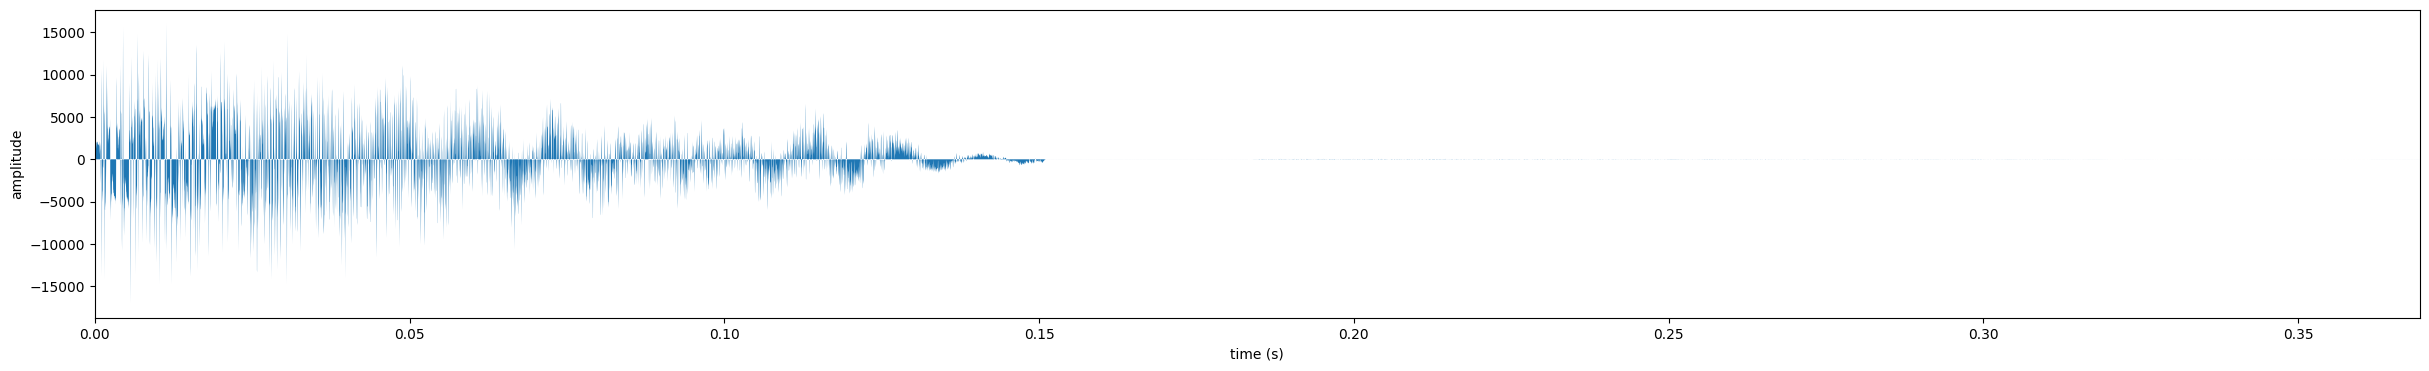

In [8]:
# plot_sound(x, times)
plot_sound(x, times)


##  Load subject HRTF

In [9]:
subject3 = loadmat("subject_003/hrir_final.mat")
subject65 = loadmat("subject_065/hrir_final.mat")


In [10]:
SUBJECT = subject3


## Problem 1: Binaural filtering

### Get the neareast HRTF given a position in space

In [11]:
def getNearestUCDpulse(azimuth, elevation, subject, verbose=True):
    elmax = 49
    elindices = np.arange(elmax + 1)
    elevations = -45 + 5.625 * (elindices)
    azimuths = np.hstack([[-80, -65, -55], np.arange(-45, 50, 5), [55, 65, 80]])

    el = round((elevation + 45) / 5.625)
    el = np.clip(el, 0, elmax)
    elerr = el - ((elevation + 45) / 5.625)

    azim = np.argmin(np.abs(azimuths - azimuth))
    azerr = np.min(np.abs(azimuths - azimuth))
    if verbose:
        print("Les parametres utilises pour la HRTF sont:")
        print("\t azimuths: {}".format(azimuths[azim]))
        print("\t elevation: {}".format(-45 + 5.625 * el))

        print("\nLes indices sont:")
        print("\t azim: {}".format(azim))
        print("\t el: {}".format(el))

    pulse = np.vstack([subject["hrir_l"][azim, el], subject["hrir_r"][azim, el]])

    return pulse


### Binaural ﬁltering for a ﬁxed position in space

#### get the hrtf for the position : right in front at 1m (0, 0)

In [12]:
hrtf = getNearestUCDpulse(70, -45, subject3)


Les parametres utilises pour la HRTF sont:
	 azimuths: 65
	 elevation: -45.0

Les indices sont:
	 azim: 23
	 el: 0


#### plot the hrtf for left ear

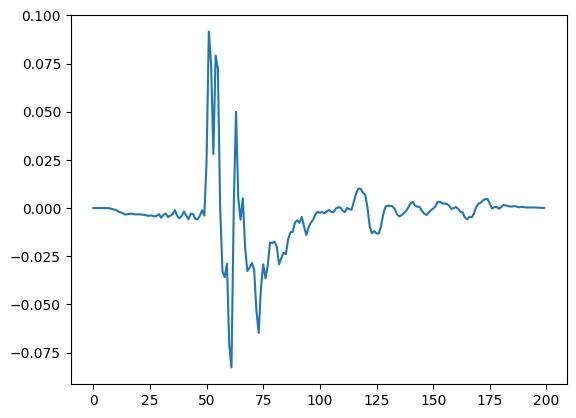

In [13]:
plt.plot(hrtf[0])


#### plot the hrtf for right ear

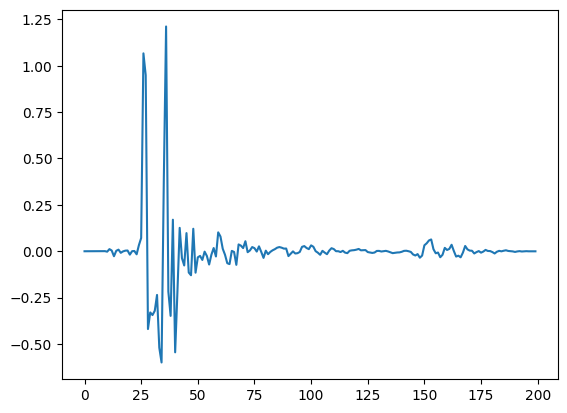

In [14]:
plt.plot(hrtf[1])


In [16]:
def load_sound(filename):
    current_path = os.getcwd()
    data_path = os.path.join(current_path, "sons")
    music = os.path.join(data_path, filename)
    wavefile = load_music(music)

    Fs = int(wavefile.getframerate())
    num_samples = int(wavefile.getnframes())
    data = wavefile.readframes(num_samples)
    data = struct.unpack("{n}h".format(n=num_samples), data)
    x = np.array(data)

    timestep = 1 / float(Fs)
    times = np.arange(len(x)) * timestep
    return music, x, wavefile.getparams(), Fs, times


def save_sound(data, params, filename):
    current_path = os.getcwd()
    data_path = os.path.join(current_path, "sons")
    music = os.path.join(data_path, filename)

    audio = data.astype("<h")
    with wave.open(music, "wb") as file:
        file.setparams(params)
        file.setnchannels(data.shape[1])
        file.writeframes(audio.tobytes())


#### Move the sound

The first experiment is to move the sound to the right. To do so, we apply a transformation on the right and left sound corresponding to a UCD pulse from the right.

In [20]:
hrtf = getNearestUCDpulse(90, 0, subject3, verbose=False)
yd = np.convolve(x, hrtf[0], mode="valid")
yg = np.convolve(x, hrtf[1], mode="valid")
data = np.array([yd, yg]).T
# new_params.setnframes = len(data)
save_sound(data, wavefile.getparams(), "right_snare2_44.wav")
print("Original sound")
display(Audio(f"sons/snare2_44.wav"))
print("Sound from the right")
display(Audio(f"sons/right_snare2_44.wav"))


Original sound


Sound from the right


### Binaural ﬁltering for a trajectory

Another good experiment is the confusion cone trajectory: we select an azimuth $\theta=30°$ and we modify the elevation.

In [29]:
yd = []
yg = []
for i in np.linspace(-40, 230, 10, dtype=int):
    hrtf = getNearestUCDpulse(30, int(i), subject3, verbose=False)
    yd.extend(np.convolve(x, hrtf[0], mode="valid"))
    yg.extend(np.convolve(x, hrtf[1], mode="valid"))
data = np.array([yd, yg]).T
save_sound(data, wavefile.getparams(), "confusion_cone_snare2_44.wav")
print("Original sound")
display(Audio(f"sons/snare2_44.wav"))
print("Confusion cone trajectory")
display(Audio(f"sons/confusion_cone_snare2_44.wav"))


Original sound


Confusion cone trajectory


Another good experiment is to make the sound do a full 360 around the head.

In [34]:
yd = []
yg = []
for i in np.linspace(-90, 90, 5, dtype=int):
    hrtf = getNearestUCDpulse(int(i), 0, subject3, verbose=False)
    yd.extend(np.convolve(x, hrtf[0], mode="valid"))
    yg.extend(np.convolve(x, hrtf[1], mode="valid"))
for i in np.linspace(90, -90, 5, dtype=int):
    hrtf = getNearestUCDpulse(int(i), 180, subject3, verbose=False)
    yd.extend(np.convolve(x, hrtf[0], mode="valid"))
    yg.extend(np.convolve(x, hrtf[1], mode="valid"))
data = np.array([yd, yg]).T
save_sound(data, wavefile.getparams(), "around_head_snare2_44.wav")
print("Original sound")
display(Audio(f"sons/snare2_44.wav"))
print("Around the head trajectory")
display(Audio(f"sons/around_head_snare2_44.wav"))


Original sound


Around the head trajectory


The funny thing is that I absolutely don't feel it passing in front of me. I feel the sound passing through my head and then behind me.

**What could you do to have a sound that moves continuously in space?**

We can split the sound in window, apply binaural filtering to the windows and sum all the windows. 



**Compare this approach with the simple "panpot" ? What are the main differences ? do
you have a preference? are the provided HRTF optimal ?**

Below is my implementation of panpot. We modify $\alpha$ so that we have an left-to-right trajectory.

In [37]:
yd = []
yg = []
for alpha in np.linspace(0, 1, 10):
    yd.extend((1 - alpha) * x)
    yg.extend(alpha * x)
data = np.array([yd, yg]).T
save_sound(data, wavefile.getparams(), "panpot_left_to_right_snare2_44.wav")
print("Original sound")
display(Audio(f"sons/snare2_44.wav"))
print("Panpot: left-to-right trajectory")
display(Audio(f"sons/panpot_left_to_right_snare2_44.wav"))


Original sound


Panpot: left-to-right trajectory


The main difference between panpot and binaural ﬁltering is that panpot can only have 1D trajectories. While I don't recognize the sound coming from the sound, I still can tell that panpot sound isn't passing in the back nor in the front. I have the feeling that the panpot sound is just fading and reapparing.

That is why I prefer the binaural filtering. However, the HRTF don't look optimal as they are not uniformly spaced. I could feel it when using more times the same snare pattern. Moreover, the computed HRTF don't correspond to my feeling, explaining why I can't feel the sound passing in front of me. 

## Problem 2: Transaural ﬁltering

> Note: I don't have the proper setup at home to test my code. Here is only my attempt to implement transaural filtering, with no clue if it works as expected.

**Express the filters $H'_{gg}$, $H'_{dd}$, $H'_{dg}$, $H'_{gd}$ from the filters $H_{gg}$, $H_{dd}$, $H_{dg}$, $H_{gd}$ corresponding to the transfer functions between a given loudspeaker and one ear.**

According to the figure, we have
$$
\begin{gather}
   \begin{bmatrix} 
      Y_d \\ Y_g
   \end{bmatrix}
 =
  \begin{bmatrix}
      H'_{gg} & -H'_{dg} \\ -H'_{gd} & H'_{dd}
   \end{bmatrix}
   \begin{bmatrix}
      Z_d \\ Z_g
   \end{bmatrix}
\end{gather}
 $$
with $Y_i$ the sound going to ear $i$, $Z_j$ the sound from speaker $j$, $H'_{ji}$ the transfert function from speaker $j$ to ear $i$.

With the notations of the lesson, this results in:
$$
\begin{gather}
\boxed{
   \begin{bmatrix}
      H_{gg} & H_{dg} \\ H_{gd} & H_{dd}
   \end{bmatrix}
 =
   \begin{bmatrix}
      H'_{gg} & -H'_{dg} \\ -H'_{gd} & H'_{dd}
   \end{bmatrix}
}
\end{gather}
$$

The goal of this problem is to reconstruct the cancelation matrix $C$ multiplying the output binaural filtering before being fed to the speaker, so that the ears listen to an approximation of the binaural filtering. In other terms, we want to find $C$ such that:
$$
x = HCX
$$
with $H$ the matrix of the speaker filters and $X$ the sound from the binaural filtering. The solution to this equation is $C=\frac{1}{H}$ which can be soved using a least square minimization problem.

First, we simulate the filter function from the HRFT. We take a symmetric setting but this is not required.

In [124]:
H_dd, H_dg = getNearestUCDpulse(30, 0, subject3, verbose=False)
H_gd, H_gg = getNearestUCDpulse(-30, 0, subject3, verbose=False)

# filter to inverse
n = len(H_gg)
Hden = H_gg * H_dd - H_dg * H_gd
H = toeplitz(c=Hden, r=[Hden[0]] + [0 for _ in range(n - 1)])

# Inversing filter
Hinv = np.linalg.pinv(H)
Hden_inv = []
for i in range(n):
    d = np.zeros(n)
    d[i] = 1
    g = Hinv @ d
    Hden_inv.append(g[i])
Hden_inv = np.array(Hden_inv)

# Compute C
C_dd = H_dd * np.array(Hden_inv)
C_dg = - H_dg * np.array(Hden_inv)
C_gd = - H_gd * np.array(Hden_inv)
C_gg = H_gg * np.array(Hden_inv)

# Compute binaural filtering on x
# we suppose x is a sound coming from the right
hrtf = getNearestUCDpulse(90, 0, subject3, verbose=False)
yd = np.convolve(x, hrtf[0], mode="valid")
yg = np.convolve(x, hrtf[1], mode="valid")
X = np.array([yd, yg]).T

# Compute the output to the speakers
modified_input_d = np.convolve(X[:, 0], C_dd, mode="valid") + np.convolve(
    X[:, 1], C_dg, mode="valid"
)
modified_input_g = np.convolve(X[:, 0], C_gd, mode="valid") + np.convolve(
    X[:, 1], C_gg, mode="valid"
)

speaker_d = np.convolve(modified_input_d, H_dd, mode="valid") -  np.convolve(
    modified_input_g, H_dg, mode="valid"
)
speaker_g =  - np.convolve(modified_input_d, H_gd, mode="valid") + np.convolve(
    modified_input_g, H_gg, mode="valid"
)

# Compute and listen final output
output = np.array([speaker_d, speaker_g]).T
save_sound(output, wavefile.getparams(), "transaural_snare2_44.wav")
print("Original sound")
display(Audio(f"sons/snare2_44.wav"))
print("Binaural sound")
display(Audio(f"sons/right_snare2_44.wav"))
print("Transaural sound. WARNING: lower the volume, as it doesn't work properly.")
display(Audio(f"sons/transaural_snare2_44.wav"))


Original sound


Binaural sound


Transaural sound. WARNING: lower the volume, as it doesn't work properly.


The current method isn't working properly. If it were, the result on binaural and transaural would be a lot closer.